<a href="https://colab.research.google.com/github/Gongsoo/Python3/blob/main/CIFAR-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [3]:
#packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import files
import PIL
import shutil
import zipfile
import glob
import os
import time

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)
train = datasets.CIFAR10(root='/gdrive/MyDrive/CIFAR10', train = True, download = 'True', transform=transform)
test = datasets.CIFAR10(root='/gdrive/MyDrive/CIFAR10', train = False, download = 'True', transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
def view_image(sample,label):
  sample = sample.permute(1,2,0)
  fig, ax = plt.subplots(1)
  ax.axis('off')
  ax.set_title(classes[label])
  ax.imshow(sample)
  plt.show()

In [7]:
def calculate_norm(dataset):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()

    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()
    
    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

In [8]:
mean_train, std_train = calculate_norm(train)

In [9]:
print(mean_train,std_train)

(0.49139965, 0.48215845, 0.4465309) (0.20220213, 0.19931543, 0.20086348)


In [9]:
transform_pre = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean_train,std_train)]
)
train = datasets.CIFAR10(root='/gdrive/MyDrive/CIFAR10', train = True, download = 'False', transform=transform)
test = datasets.CIFAR10(root='/gdrive/MyDrive/CIFAR10', train = False, download = 'False', transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
train, valid= train_test_split(train, random_state = 42, test_size = 0.2)

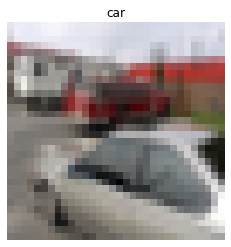

In [13]:
view_image(train[49999][0],train[49999][1])

In [11]:
batch_size = 32
train_data_loader = torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle = True)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=batch_size,shuffle = True)
test_data_loader = torch.utils.data.DataLoader(test,batch_size=batch_size,shuffle = True)

In [12]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [68]:
class CNN(nn.Module) :
  def __init__(self) :
    super().__init__()
    self.features = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels = 64,kernel_size = (3,3), stride = 1, padding = 1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(in_channels=64, out_channels = 192,kernel_size = (3,3), stride = 1, padding = 1),
      nn.BatchNorm2d(192),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      nn.Conv2d(in_channels=192, out_channels = 384,kernel_size = (3,3), stride = 1, padding = 1),
      nn.BatchNorm2d(384),
      nn.ReLU(),
      nn.Conv2d(in_channels=384, out_channels = 512,kernel_size = (3,3), stride = 1, padding = 1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      nn.Conv2d(in_channels=512, out_channels = 256,kernel_size = (3,3), stride = 1, padding = 1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.Conv2d(in_channels=256, out_channels = 256,kernel_size = (3,3), stride = 1, padding = 1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.AvgPool2d(2,2)
      
    )
    self.classifier = nn.Sequential(
      nn.Linear(256*4*4,4096),
      nn.Linear(4096,2048),
      nn.Linear(2048,10)

    )

  def forward(self, x) :
    x = self.features(x)
    x = torch.flatten(x,1)
    x = self.classifier(x)
    x = F.log_softmax(x, dim=1)
    return x


In [69]:
model = CNN()
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(384, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=

In [70]:
from torchsummary import summary
model.cuda()
summary(model,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 192, 32, 32]         110,784
       BatchNorm2d-5          [-1, 192, 32, 32]             384
              ReLU-6          [-1, 192, 32, 32]               0
         MaxPool2d-7          [-1, 192, 16, 16]               0
            Conv2d-8          [-1, 384, 16, 16]         663,936
       BatchNorm2d-9          [-1, 384, 16, 16]             768
             ReLU-10          [-1, 384, 16, 16]               0
           Conv2d-11          [-1, 512, 16, 16]       1,769,984
      BatchNorm2d-12          [-1, 512, 16, 16]           1,024
             ReLU-13          [-1, 512, 16, 16]               0
        MaxPool2d-14            [-1, 51

In [71]:
epochs = 20
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [72]:
for epoch in range(1,epochs+1) :
  train_loss = 0
  train_acc = 0
  train_correct = 0
  for train_x, train_y in train_data_loader :
    model.train()
    train_x, train_y = train_x.to(device), train_y.to(device)
    optimizer.zero_grad()
    pred = model(train_x)
    loss = criterion(pred, train_y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    output = pred.argmax(1)
    train_correct += output.eq(train_y.view_as(output)).sum().item()

  valid_loss = 0
  alid_acc = 0
  valid_correct = 0

  for valid_x, valid_y in valid_data_loader :
    with torch.no_grad():
      model.eval()
      valid_x, valid_y = valid_x.to(device), valid_y.to(device)
      val_pred = model(valid_x)
      val_loss = criterion(val_pred, valid_y)
    valid_loss += val_loss.item()

    val_output = val_pred.argmax(1)
    valid_correct += val_output.eq(valid_y.view_as(val_output)).sum().item()
  
  train_acc = train_correct/len(train_data_loader.dataset)
  valid_acc = valid_correct/len(valid_data_loader.dataset)

  print("[Epoch {}/{}] Train Loss: {:.6f} Train Acc: {:.3f}% / Valid Loss: {:.6f} Valid Acc: {:.3f}%".format(
      epoch,epochs,train_loss/len(train_data_loader),train_acc*100,valid_loss/len(valid_data_loader),valid_acc*100
  ))

[Epoch 1/20] Train Loss: 2.051313 Train Acc: 39.730% / Valid Loss: 1.340254 Valid Acc: 51.570%
[Epoch 2/20] Train Loss: 1.120088 Train Acc: 60.280% / Valid Loss: 0.964519 Valid Acc: 65.790%
[Epoch 3/20] Train Loss: 0.847648 Train Acc: 70.642% / Valid Loss: 0.799737 Valid Acc: 71.780%
[Epoch 4/20] Train Loss: 0.673511 Train Acc: 76.905% / Valid Loss: 0.917150 Valid Acc: 69.440%
[Epoch 5/20] Train Loss: 0.566455 Train Acc: 80.787% / Valid Loss: 0.668833 Valid Acc: 77.640%
[Epoch 6/20] Train Loss: 0.464004 Train Acc: 84.215% / Valid Loss: 0.592806 Valid Acc: 80.920%
[Epoch 7/20] Train Loss: 0.392938 Train Acc: 86.610% / Valid Loss: 0.542689 Valid Acc: 82.760%
[Epoch 8/20] Train Loss: 0.311259 Train Acc: 89.405% / Valid Loss: 0.521162 Valid Acc: 83.730%
[Epoch 9/20] Train Loss: 0.263842 Train Acc: 91.197% / Valid Loss: 0.628628 Valid Acc: 83.240%
[Epoch 10/20] Train Loss: 0.217789 Train Acc: 92.802% / Valid Loss: 0.637021 Valid Acc: 82.590%
[Epoch 11/20] Train Loss: 0.177972 Train Acc: 94.

In [74]:
torch.save(model, f'/gdrive/MyDrive/CIFAR10/CNNv1.pt')

In [101]:
def predict(model, data_loader):
    with torch.no_grad():
        model.eval()
        ret = None
        real = []
        for img, files in data_loader:
            img = img.to(device)
            pred = model(img)
            real.extend(files)
            if ret is None:
                ret = pred.cpu().numpy()
            else:
                ret = np.vstack([ret, pred.cpu().numpy()])
    return ret,real
   
pred, label = predict(model, test_data_loader)

In [99]:
print(len(label))

10000


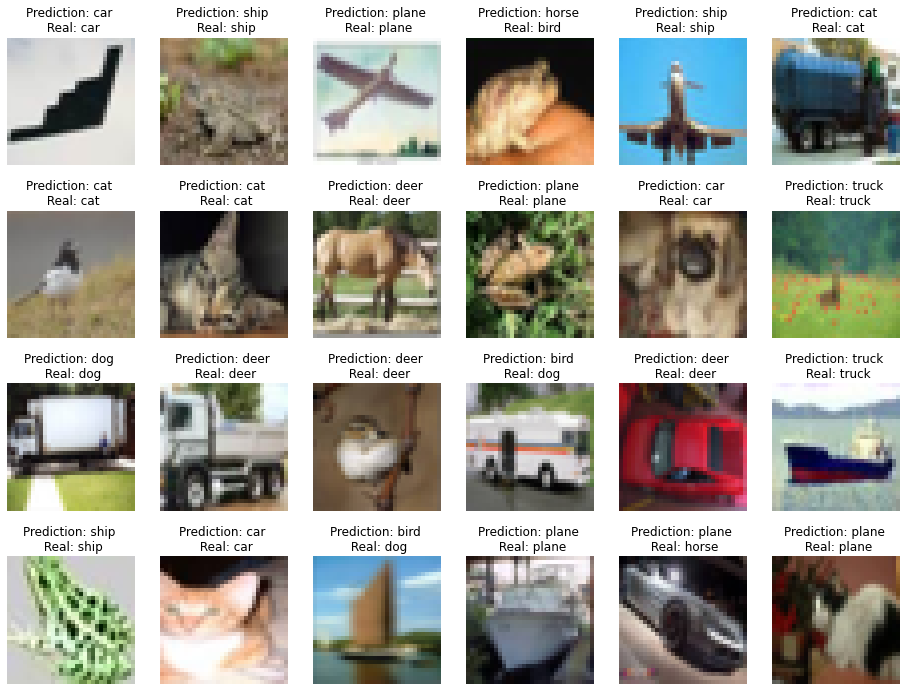

In [102]:
pred_sample, real_label = pred[:24], label[:24]

img,file = next(iter(test_data_loader))
fig = plt.figure(figsize=(16,24))
for i in range(24) :
  a = fig.add_subplot(4,6,i+1)
  a.set_title("Prediction: {} \n Real: {}".format(classes[pred_sample[i].argmax()],classes[real_label[i]]))
  a.axis('off')
  a.imshow(np.transpose(img[i].numpy(),(1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)